In [3]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time, warnings
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle, islice
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

In [4]:
iris = pd.read_csv('iris.csv')

iris.head()

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
iris = iris.iloc[:,iris.columns != 'class']
scaler = StandardScaler()
scaler.fit(iris)
iris_scaled = scaler.transform(iris)

In [6]:
# Set up cluster parameters
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02,right=.98,bottom=.001,top=.96,wspace=.05,hspace=.01)
plot_num = 1
1
default_base = {'quantile': .3,'eps': .3, 'damping': .9, 'preference': -200, 'n_neighbors': 10, 'n_clusters': 3}
datasets = [
(iris_scaled,{'damping':.77,'preference':-240,'quantile':.2,'n_clusters':2}),
(iris_scaled, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
(iris_scaled, {'eps': .18, 'n_neighbors': 3}),
(iris_scaled, {'eps': .15, 'n_neighbors': 2}),
(iris_scaled, {}),
(iris_scaled, {})]

<Figure size 21600x21600 with 0 Axes>

In [17]:
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)
    X = dataset
    
    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    # Create cluster objects
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering( n_clusters=params['n_clusters'], linkage='ward',
    connectivity=connectivity)
    spectral = cluster.SpectralClustering( n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering( linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture( n_components=params['n_clusters'], covariance_type='full')
    clustering_algorithms = (('MiniBatchKMeans', two_means),('AffinityPropagation', affinity_propagation),('MeanShift', ms),('SpectralClustering', spectral),('Ward', ward),('AgglomerativeClustering', average_linkage),('DBSCAN', dbscan),('Birch', birch),('GaussianMixture', gmm))

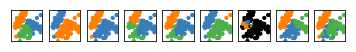

In [18]:
y_preds = {}
for name, algorithm in clustering_algorithms:
    t0 = time.time()
    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore",message="the number of connected components of the " +"connectivity matrix is [0-9]{1,2}" +" > 1. Completing it to avoid stopping the tree early.",category=UserWarning)
        warnings.filterwarnings("ignore",message="Graph is not fully connected, spectral embedding" +" may not work as expected.",category=UserWarning)
        algorithm.fit(X)
        t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)
    y_preds[name] = y_pred
    plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
    if i_dataset == 0:
        plt.title(name, size=18)
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plot_num += 1
    plt.savefig('{}.pdf'.format(name))
    

In [19]:
from sklearn.metrics import silhouette_score
for name in y_preds:
    s_score = silhouette_score(X, y_preds[name])
    print('{} silhouette score {}'.format(name, s_score))

MiniBatchKMeans silhouette score 0.4589717867018717
AffinityPropagation silhouette score 0.580184463257396
MeanShift silhouette score 0.580184463257396
SpectralClustering silhouette score 0.37685652586482404
Ward silhouette score 0.44553956399200406
AgglomerativeClustering silhouette score 0.47945127284080863
DBSCAN silhouette score -0.19270408088662622
Birch silhouette score 0.45229953312181903
GaussianMixture silhouette score 0.3727731874570307


In [27]:
from sklearn.metrics import adjusted_rand_score
iris = pd.read_csv('iris.csv')
y = iris[['class']]
for name in y_preds:
    ad_rand = adjusted_rand_score(y.values.ravel(), y_preds[name])
    print('{} adjusted rand score score {}'.format(name, ad_rand))

MiniBatchKMeans adjusted rand score score 0.6201351808870379
AffinityPropagation adjusted rand score score 0.5681159420289855
MeanShift adjusted rand score score 0.5681159420289855
SpectralClustering adjusted rand score score 0.41868242113476767
Ward adjusted rand score score 0.615322993214545
AgglomerativeClustering adjusted rand score score 0.5621364251426576
DBSCAN adjusted rand score score 0.0875953843594118
Birch adjusted rand score score 0.6614133258247838
GaussianMixture adjusted rand score score 0.9038742317748124
